In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[0:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


### Dataset

In [4]:
block_size = 3

def build_dataset(words):
    X = []
    Y = []

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Initializing MLP

In [5]:
n_embd = 10
n_hidden = 200
n_input = n_embd * block_size

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn(n_input, n_hidden,             generator=g) * (5/3)/(n_input**0.5)
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn(n_hidden, vocab_size,          generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

12297

### Training

In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(-1, n_input)
    hpreact = embcat @ W1 + b1
    
    # batch normalization
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # non linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) 
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


##### logits are highly varied which gives rise to high initial loss

In [7]:
logits

tensor([[-2.9432e+00,  1.7033e+00, -1.4905e-01, -6.3368e-01, -2.5059e-01,
          1.9912e+00, -1.0582e+00, -1.1586e+00, -1.6838e-02,  2.3001e+00,
         -2.0891e+00, -1.5072e+00,  2.9150e+00,  1.6253e+00,  2.9859e+00,
          7.8322e-01, -6.3823e-01, -3.9365e+00,  1.3895e+00,  1.1865e+00,
          8.4649e-01, -1.4758e+00,  3.4494e-01, -2.4001e+00, -2.2058e+00,
          2.5447e+00, -3.1198e-01],
        [ 2.9649e+00,  1.9056e+00, -2.5911e+00,  1.6022e+00,  2.0173e+00,
          1.6680e+00, -1.4427e+00,  1.7896e-01, -5.6759e-01,  9.5239e-03,
         -6.8699e-01,  3.7275e-01,  2.3225e+00, -4.0931e-01,  3.4398e+00,
          6.2853e-01, -3.7287e+00, -3.1159e+00, -1.0541e+00,  2.6985e+00,
          1.1964e+00, -8.7484e-01, -2.0182e+00, -2.5398e+00,  1.2156e+00,
         -8.4740e-01, -1.8617e+00],
        [ 4.4101e+00,  2.1192e+00, -1.3341e+00,  1.7164e+00,  2.7371e+00,
          1.6880e+00, -3.2578e+00,  1.5312e-01, -1.3826e+00,  3.2539e+00,
         -3.0283e-01,  1.1905e+00,  2.27

##### Most of the values after activation are either 1 or -1. Gradients of tanh are 0 which stops the backpropagation.

(array([463., 241., 185., 165., 147., 111.,  97., 124.,  93., 102., 107.,
         76., 107.,  95., 108., 113.,  89.,  96., 112.,  93., 118.,  85.,
         67., 132., 111., 112., 106., 107.,  85.,  92., 103.,  80.,  93.,
         91.,  81.,  93., 120.,  82., 118., 110., 103., 103., 110., 114.,
        114., 135., 166., 171., 242., 432.]),
 array([-9.99993980e-01, -9.59995645e-01, -9.19997311e-01, -8.79998976e-01,
        -8.40000641e-01, -8.00002307e-01, -7.60003972e-01, -7.20005637e-01,
        -6.80007303e-01, -6.40008968e-01, -6.00010633e-01, -5.60012299e-01,
        -5.20013964e-01, -4.80015630e-01, -4.40017295e-01, -4.00018960e-01,
        -3.60020626e-01, -3.20022291e-01, -2.80023956e-01, -2.40025622e-01,
        -2.00027287e-01, -1.60028952e-01, -1.20030618e-01, -8.00322831e-02,
        -4.00339484e-02, -3.56137753e-05,  3.99627209e-02,  7.99610555e-02,
         1.19959390e-01,  1.59957725e-01,  1.99956059e-01,  2.39954394e-01,
         2.79952729e-01,  3.19951063e-01,  3.59949

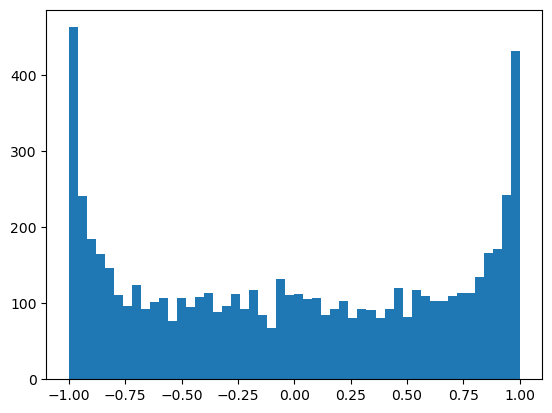

In [8]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   0.,   2.,   1.,   1.,   2.,   4.,  11.,  14.,
         18.,  13.,  19.,  42.,  54.,  66.,  84., 103., 123., 170., 216.,
        262., 273., 347., 423., 524., 599., 537., 456., 416., 323., 247.,
        240., 185., 148., 129.,  81.,  82.,  57.,  39.,  29.,  19.,  16.,
         11.,   5.,   3.,   2.,   1.,   2.]),
 array([-6.35467863, -6.12596539, -5.89725216, -5.66853892, -5.43982569,
        -5.21111245, -4.98239922, -4.75368598, -4.52497274, -4.29625951,
        -4.06754627, -3.83883304, -3.6101198 , -3.38140656, -3.15269333,
        -2.92398009, -2.69526686, -2.46655362, -2.23784039, -2.00912715,
        -1.78041391, -1.55170068, -1.32298744, -1.09427421, -0.86556097,
        -0.63684773, -0.4081345 , -0.17942126,  0.04929197,  0.27800521,
         0.50671844,  0.73543168,  0.96414492,  1.19285815,  1.42157139,
         1.65028462,  1.87899786,  2.1077111 ,  2.33642433,  2.56513757,
         2.7938508 ,  3.02256404,  3.25127728,  3.47999051,  3.70870375,
 

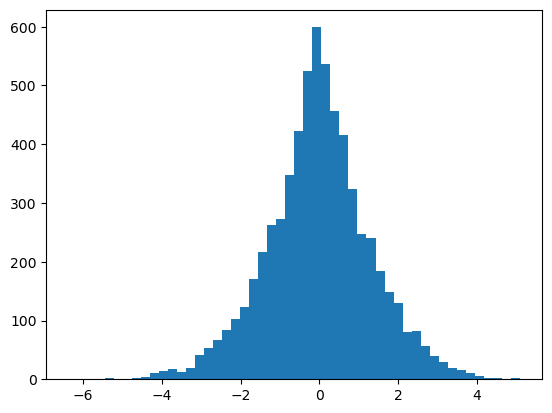

In [9]:
plt.hist(hpreact.view(-1).tolist(), 50)

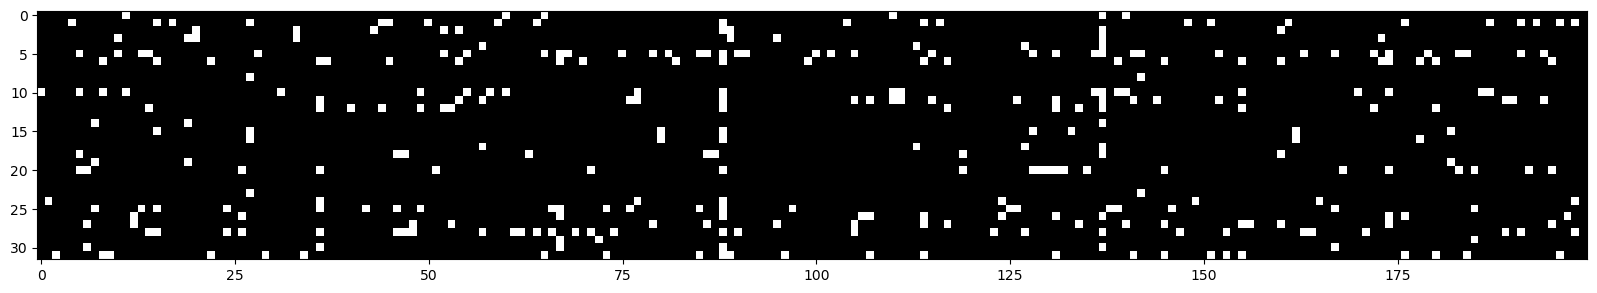

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')
# whites represent the values of h close to -1 or 1

There is possibility of having dead neurons where for any example, tanh is always 1 or -1 and the gradient is always 0 which means the neuron never learns.

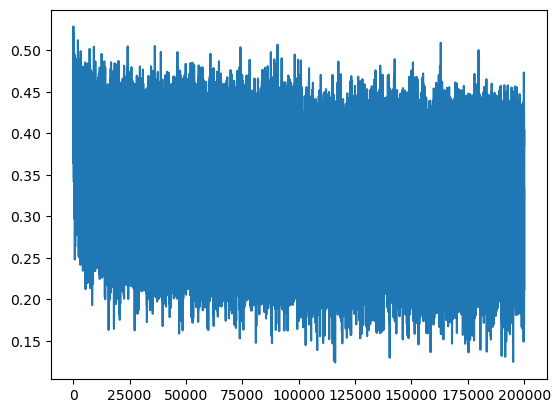

In [11]:
plt.plot(lossi)

### Loss on dev dataset

In [12]:
# calculate batch norm mean and std at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(-1, n_input)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [13]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtst, Ytst)
    }[split]
    emb = C[x]
    embcat = emb.view(-1, n_input)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


### Sample from the model

In [14]:
g = torch.Generator().manual_seed(2147483647 + 100)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    
    print(''.join(itos[i] for i in out))

blahkinsthekyefusabrustvatth.
braclysssie.
sashvikalvinslaydansh.
qufferriffern.
gfirbdwon.
farissophmerlynnshvnntvi.
sassndrwyn.
dastellennyynannaknsonestll.
bluysn.
saddmantss.
styfnanishb.
jubraysh.
shanncx.
luneispzusii.
briyanyah.
jaylidannasussnntvathalistaphlaznbrdha.
blak.
bluviyahsundi.
braycermonssetzonnikjtlfoltnngton.
sarmstefklwr.


### Fixing initial loss

In [15]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-1.2464, -9.8297,  1.4572,  5.6693]),
 tensor([9.7673e-04, 1.8285e-07, 1.4585e-02, 9.8444e-01]),
 tensor(4.2277))

Logits have to be roughly equal when the network is initialized. That way, the model predicts the probability of all characters as almost same initially.

During initialization we can set b2 as 0 and W2 as roughly 0 (not exactly 0)

#### Kaiming init

tensor(-0.0091) tensor(0.9924)
tensor(0.0005) tensor(0.9733)


(array([4.72581297e-05, 9.45162594e-05, 1.18145324e-04, 2.12661584e-04,
        3.07177843e-04, 7.32501011e-04, 1.34685670e-03, 1.98484145e-03,
        3.54435973e-03, 5.05661988e-03, 8.88452839e-03, 1.42246970e-02,
        2.22822082e-02, 3.53727101e-02, 5.29999925e-02, 7.80940594e-02,
        1.10135071e-01, 1.46594718e-01, 2.02193908e-01, 2.59588907e-01,
        3.23647301e-01, 3.75796647e-01, 4.25110506e-01, 4.39429719e-01,
        4.25795749e-01, 3.89288844e-01, 3.40565712e-01, 2.89314270e-01,
        2.19892078e-01, 1.71263462e-01, 1.24052590e-01, 8.67422971e-02,
        6.06794386e-02, 3.81845688e-02, 2.59210841e-02, 1.74146208e-02,
        1.12238058e-02, 6.80517068e-03, 3.92242477e-03, 2.74097152e-03,
        1.89032519e-03, 1.11056605e-03, 5.43468492e-04, 2.59919713e-04,
        2.12661584e-04, 9.45162594e-05, 2.36290649e-05, 4.72581297e-05,
        0.00000000e+00, 2.36290649e-05]),
 array([-5.01121473, -4.79961093, -4.58800713, -4.37640332, -4.16479952,
        -3.95319571, 

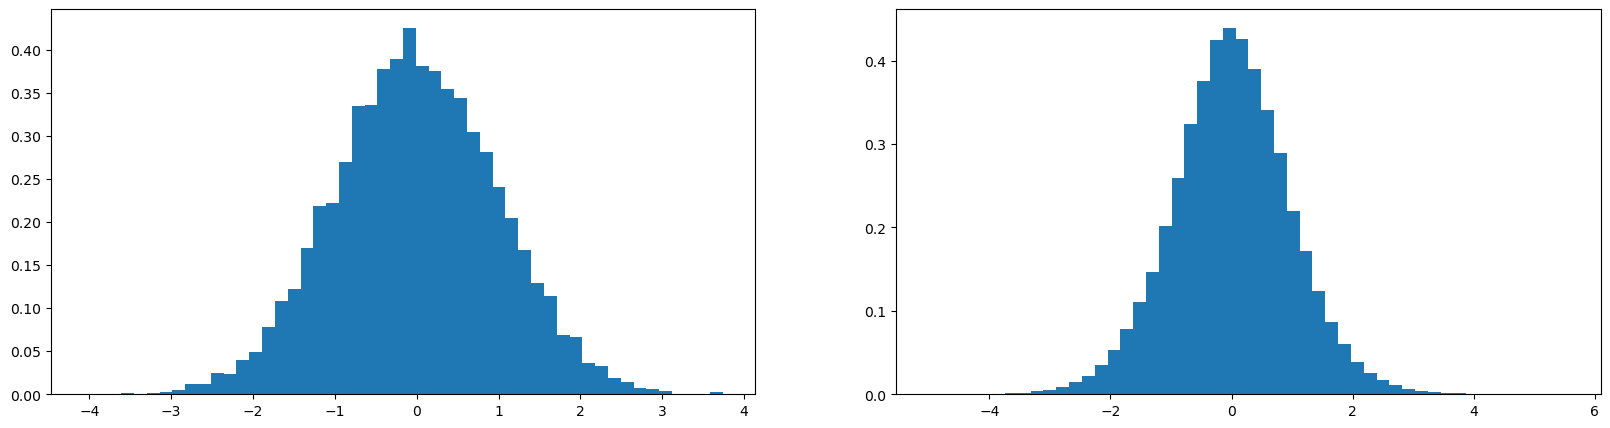

In [16]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

### BatchNorm

Make the input to tanh roughly Gaussian such that tanh is not saturated

## Tracking loss
<b>Starting values</b>
<ul>
    <li>train 2.1189513206481934</li>
    <li>val 2.161724805831909</li>
</ul>

<b>Fixing initial loss (softmax confidently wrong)</b>
<ul>
    <li>train 2.069324493408203 </li>
    <li>val 2.133209228515625</li>
</ul>

<b>Fixing saturating tanh</b>
<ul>
    <li>train 2.0343782901763916 </li>
    <li>val 2.1024086475372314</li>
</ul>

<b>Kaiming init</b>
<ul>
    <li>train 2.037754774093628 </li>
    <li>val 2.1032512187957764</li>
</ul>

<b>Batch normalization</b> not much improvement since our network is not deep
<ul>
    <li>train 2.065701723098755</li>
    <li>val 2.1107821464538574</li>
</ul>





## PyTorch-ify

##### Defining layers

In [252]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters to train
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # batch mean and variance
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        # normalize the input
        xhat = (x - xmean)/ torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
        

##### Initializing NN 

In [253]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size),
]

# layers = [
#     Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(         n_hidden, vocab_size), BatchNorm1d(vocab_size),
# ]

with torch.no_grad():
    # last layer - make less confident while initialization
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    
    # remaining layers - apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
            # higher gain - activations become saturated, gradients become close to zero in deeper layers
            # lower gain - activations become close to zero, gradients increase in deeper layers
            # only at the correct value of 5/3, activations and gradients of all layers are similar
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


##### Training

In [254]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb) 
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i> 1000:
        break

      0/ 200000: 3.2962


In [158]:
[(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]

[-2.9986276626586914,
 -2.626828908920288,
 -2.0812344551086426,
 -2.5246450901031494,
 -2.2402758598327637,
 -2.550419569015503,
 -2.285573959350586,
 -2.533825635910034,
 -2.2286269664764404,
 -2.4165804386138916,
 -2.0024101734161377,
 -1.7317665815353394,
 -2.1839237213134766]

#### Activation distribution

layer 1 (Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer 3 (Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer 5 (Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer 7 (Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer 9 (Tanh): mean -0.01, std 0.71, saturated: 11.22%


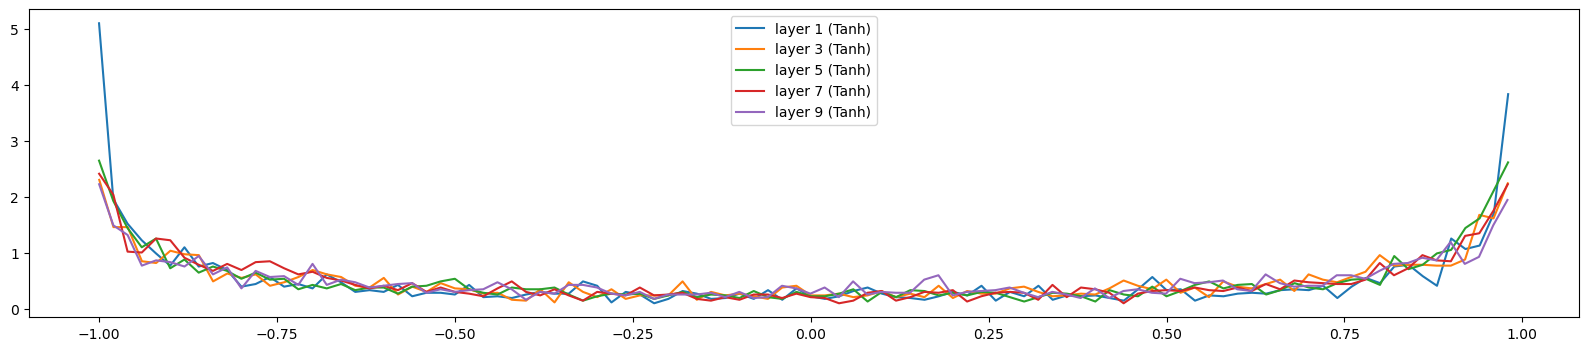

In [255]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():+.2f}, std {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)

#### Gradients distribution

layer 1 (Tanh): mean -0.000005, std 3.059083e-03
layer 3 (Tanh): mean +0.000037, std 3.085332e-03
layer 5 (Tanh): mean -0.000007, std 2.888205e-03
layer 7 (Tanh): mean +0.000012, std 2.756316e-03
layer 9 (Tanh): mean +0.000007, std 2.337389e-03


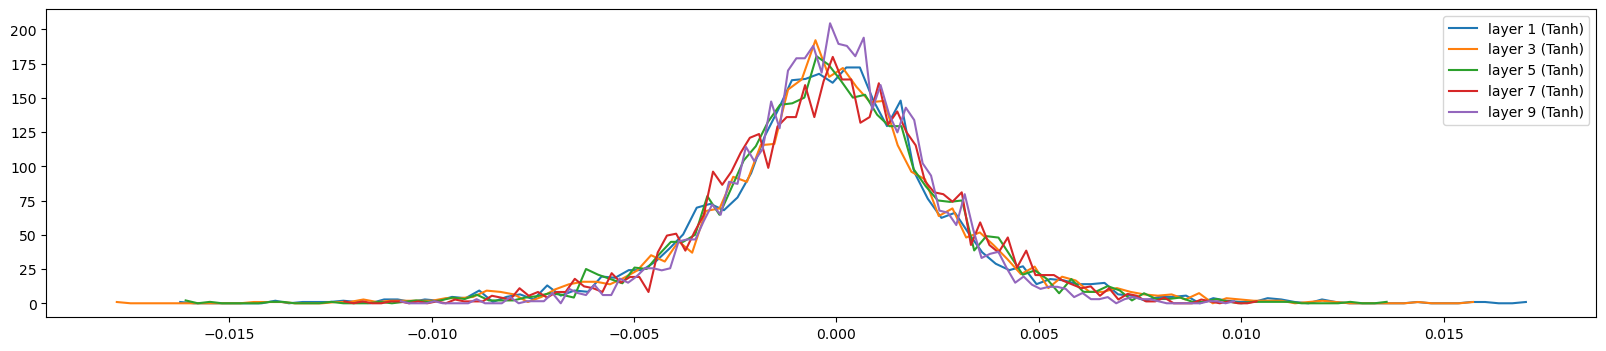

In [256]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():+f}, std {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)

#### Weights gradient distribution

weight (27, 10)   | mean +0.000772, std 0.0097, parameters std 1.000012e+00 | grad:data ratio  9.714501e-03
weight (30, 100)  | mean -0.000036, std 0.0087, parameters std 3.127304e-01 | grad:data ratio  2.792835e-02
weight (100, 100) | mean +0.000085, std 0.0074, parameters std 1.680779e-01 | grad:data ratio  4.417369e-02
weight (100, 100) | mean +0.000055, std 0.0062, parameters std 1.695316e-01 | grad:data ratio  3.681916e-02
weight (100, 100) | mean +0.000007, std 0.0062, parameters std 1.687842e-01 | grad:data ratio  3.650615e-02
weight (100, 100) | mean +0.000069, std 0.0052, parameters std 1.683281e-01 | grad:data ratio  3.102275e-02
weight (100, 27)  | mean -0.000000, std 0.0228, parameters std 7.063307e-02 | grad:data ratio  3.229573e-01


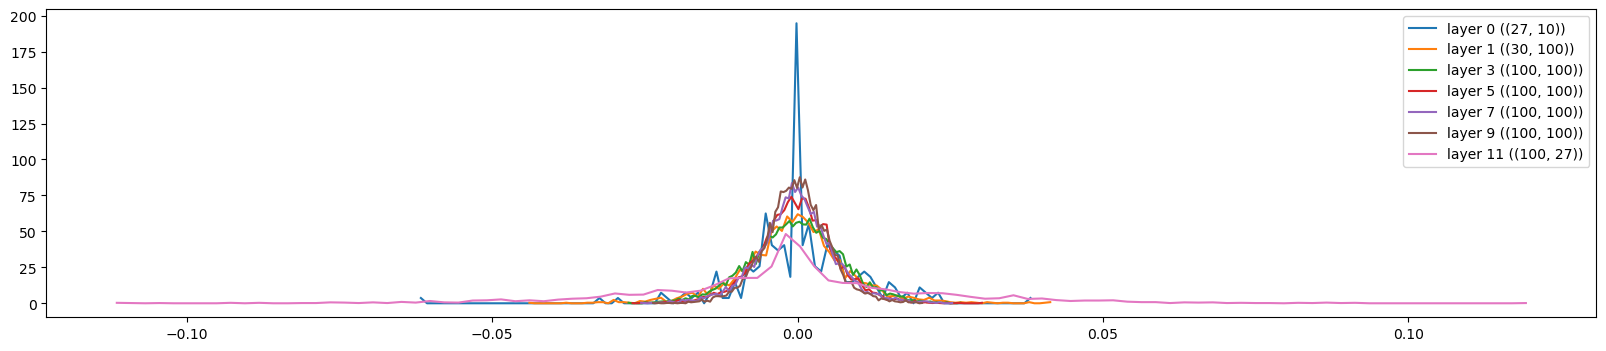

In [258]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f'weight {str(tuple(p.shape)):10s} | mean {t.mean():+f}, std {t.std():.4f}, parameters std {p.std():e} | grad:data ratio {t.std() / p.std() : e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({tuple(p.shape)})')
plt.legend(legends)

For the last output layer, gradient values are higher than the weights. This means they are getting trained at a higher learning rate

#### Update ratios over time

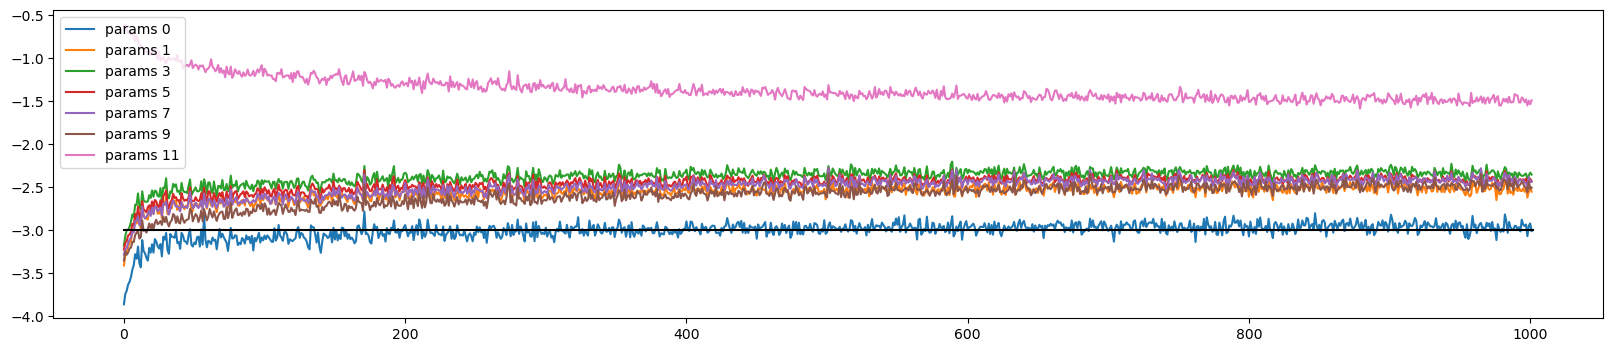

In [259]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'params {i}')
plt.plot([0, len(ud)], [-3, -3], 'k') #update ratio is expected to be roughly 1e-3.
plt.legend(legends)

This plot helps in understanding the update rate for each layer and adjust the learning rates

1002